# Simulation of $Z_2$ gauge theory including readout-error mitigation

**Date created:** 03/24/2022

**Last edited:** 05/10/2022

**Authors:**
- Clement Charles ()
- Florian Herren (Fermilab, fherren@fnal.gov)
- Sara Starecheski ()
- Ruth Van de Water (Fermilab, ruthv@fnal.gov)

**Description:**

**Outline:**

- Import modules
- Read in input parameters from file
- Get IBM provider & select backend
- Build circuit using function from `Trotterization` moudule
- Run simulation
- Save data to cloud

## Import modules

In [7]:
#Standard modules
import sys
import numpy as np
import yaml

#Qiskit modules
from qiskit import IBMQ, QuantumCircuit, transpile, QuantumRegister
from qiskit.providers.ibmq import RunnerResult
from qiskit.providers.aer import noise
from qiskit.providers.ibmq import least_busy
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_histogram

#Project modules
sys.path.append('./modules/')
sys.path.append('./inputs/')
sys.path.append('./plots/')
from Z2analysis import nqubits2nsites
import Trotterization as Trot

# for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import Image
plt.rcParams["figure.autolayout"] = True
colors = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline

#For testing reload modules after edits
from importlib import reload
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


_**Function to-dos:**_
- Create new module `SaveData.py` (or something similar) to hold functions for automatically adding results & `JSON` files to cloud database. 
- Code for gauge-invariant state-preparation for arbitrary number of sites`

## Get input parameters from `yaml` file

In [12]:
### get run parameters from YAML input file ###

stream = open('inputs/Z2_input.yaml', 'r')
dict_in = yaml.safe_load(stream)
stream.close()

account_info = dict_in['account_info'] # dictionary of account information
backend_opts = dict_in['backend_opts']   # dictionary of machine/simulator choices
simulation_opts = dict_in['simulation_opts'] # dictionary of lattice-simulation parameters
runtime_opts = dict_in['runtime_opts'] # dictionary of runtime parameters

### Lattice parameters ###
mass = simulation_opts['lattice_params']['mass']       #fermion mass in lattice-spacing units
nsites = simulation_opts['lattice_params']['nsites']   #must be even for staggered simulation
nqubits = nqubits2nsites(nsites)

### Time evolution ###
tf = simulation_opts['time_evolution']['tf']       # total time interval in lattice-spacing units
ntrotter = simulation_opts['time_evolution']['tf'] # number of trotter steps
epsilon = tf/ntrotter                              # step size in lattice-spacing units

### Pauli Twirling ###
twirl = simulation_opts['pauli_twirling']['twirl']     # if True, apply Pauli twirling
ntwirls = simulation_opts['pauli_twirling']['ntwirls'] # number of Pauli twirls

### Richardson ??? ###
richardson_level = simulation_opts['richardson_level'] # number of CNOTs for Richardson smearing

In [3]:
'''
def gauge_kinetic(epsilon):
    circuit=QuantumCircuit(1)
    circuit.rx(-epsilon/2,0)
    U_kg = circuit.to_gate()
    U_kg.name = 'U$_{Kg}$'
    return U_kg

def fermion_mass(epsilon,mass,eta):
    circuit=QuantumCircuit(1)
    circuit.rz(-epsilon*mass * eta,0)
    U_m = circuit.to_gate()
    U_m.name = 'U$_m$'
    return U_m

def fermion_hopping_opt2(epsilon,eta):
    circuit= QuantumCircuit(3)
    circuit.cx(0,2)
    circuit.h(0)
    circuit.cx(1,0)
    circuit.cx(0,2)
    circuit.rz(epsilon/4 * eta,0)
    circuit.rz(-epsilon/4 * eta,2)
    circuit.cx(0,2)
    circuit.cx(1,0)
    circuit.h(0)
    circuit.cx(0,2)
    U_fho2 = circuit.to_gate()
    U_fho2.name = 'U$_{fho2}$'
    return U_fho2

#prepare the quantum circuit for each Trotter step
def build_circuit(nqubits,T):
    qc = QuantumCircuit(nqubits, nqubits)
    qc.x(0)
    qc.h(0)
    for t in range(T):
        for n in range(0,nqubits+1,2):
            qc.append(fermion_mass(epsilon,mass,(-1)**(n/2+1)),[n])
        for l in range(1,nqubits,2):
            qc.append(gauge_kinetic(epsilon),[l])
        for n in range(0,nqubits-2,2):
            qc.append(fermion_hopping_opt2(epsilon, (-1)**(n/2)),[n,n+1,n+2])    
    qc.measure(range(nqubits), range(nqubits))
    return qc
'''

## Initialize IBM Quantum account

To-do:

- Save IBM Quantum API token so that notebook/script can be run in terminal on personal machine.

In [10]:
### initialize IBM Quantum account ###

IBMQ.load_account()
hub = account_info['hub']
group = account_info['group']
project = account_info['project']
provider = IBMQ.get_provider(hub=hub, group=group, project=project)

## Choose target backend for Qiskit Runtime program

Can be real machine or `qasm_simulator`

_Move this junk to functions..._

In [50]:
def get_backend(provider, machine, nqubits, simulator, sim_noise):
    
    ## Run on IBMQ qasm simulator
    if (simulator):
        backend = provider.get_backend('ibmq_qasm_simulator')
        
        if (sim_noise):
            device_backend = provider.get_backend(sim_noise)
            noise_model = noise.NoiseModel.from_backend(device_backend)
            backend.set_options(noise_model=noise_model.to_dict())
            
        print(f'Running on ibmq_qasm_simulator with {sim_noise} noise_model\n') 
        
    ## Run on specified quantum computer(s)
    else:
        devices = provider.backends(filters=lambda x: not x.name() == 'ibmq_casablanca'
                                    and nqubits <= x.configuration().n_qubits <= 7
                                    and not x.configuration().simulator
                                    and x.status().operational == True)
        print(type(devices))
        print(type(devices[0]))
        #print(f'Backends matching critera ares {devices}\n')
        #print(device_names)
        
        if (machine == 'least_busy'):
            machine = str(least_busy(devices))
            backend = provider.get_backend(machine)    
        
        elif (machine[0:4] == 'ibmq_'):
            backend = provider.get_backend(machine)   
            
        else:
            backend = provider.get_backend(str(machine))
            
        print(f'Running on machine {machine}\n')
        

In [51]:
### choose target backend for Qiskit Runtime program ###

machine
machine = backend_opts['machine']           # machine name or "least busy"
simulator = False#backend_opts['qasm_simulator']  # if True, use ibmq_qasm_simulator 
noise_model = backend_opts['noise_model']   # None or device noise model 

backend = get_backend(provider, machine, nqubits, simulator, noise_model)

'''
if (simulation):
    backend = provider.get_backend('ibmq_qasm_simulator')
    device_backend = provider.get_backend(sim_noise)
    noise_model = noise.NoiseModel.from_backend(device_backend)
        
    backend.set_options(noise_model=noise_model.to_dict())
    print(f'Running on backend {backend} with {sim_noise} noise_model\n') 
        
else:
    
    devices = provider.backends(filters=lambda x: not x.name() == 'ibmq_casablanca'
                                      and x.configuration().n_qubits == 7
                                      and not x.configuration().simulator
                                      and x.status().operational == True)
    print(f'Backends matching critera ares {small_devices}\n')
    
    machine = least_busy(devices)
    backend = provider.get_backend(str(machine))     
    print(f'Running on machine {machine}\n')
'''

<class 'list'>
<class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'>
Running on machine ibm_perth



"\nif (simulation):\n    backend = provider.get_backend('ibmq_qasm_simulator')\n    device_backend = provider.get_backend(sim_noise)\n    noise_model = noise.NoiseModel.from_backend(device_backend)\n        \n    backend.set_options(noise_model=noise_model.to_dict())\n    print(f'Running on backend {backend} with {sim_noise} noise_model\n') \n        \nelse:\n    \n    devices = provider.backends(filters=lambda x: not x.name() == 'ibmq_casablanca'\n                                      and x.configuration().n_qubits == 7\n                                      and not x.configuration().simulator\n                                      and x.status().operational == True)\n    print(f'Backends matching critera ares {small_devices}\n')\n    \n    machine = least_busy(devices)\n    backend = provider.get_backend(str(machine))     \n    print(f'Running on machine {machine}\n')\n"

## Define runtime program _(and inputs)_

_Assigns values read from `YAML` input file_

_(I'm not really sure what the `program_id` is needed for)_

In [7]:
# number of shots per simulation
nshots = runtime_opts['nshots'] 

# Not really sure what this is needed for...
program_id = runtime_opts['program_id']

# correct for readout error using calibration matrix if True
measurement_error_mitigation = runtime_opts['readout_error_mitigation'] 

#save results for each shot if True
memory = runtime_opts['memory'] 

# Degree of layout optimization by transpiler
# 1 is least optimized; 3 is most optimized
optimization_level = runtime_opts['optimization_level'] 

## Invoke runtime program

_For simulator, append t_qc to t_mc and transpile/run both at the same time_

_Need to know how to get circuit diagram in sensible format to save_

_Need to know how to deal w/ file system_

In [15]:
# lists to hold information for each Trotter step
noisy_counts = [] # noisy counts
mitigated_counts = []
noisy_data_allshots = []
tvals = [] # Trotter-step times

# calculate calibration matrix once and apply to all simulation runs
# follows example in qiskit textbook at
# https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html
if (simulation):
        qr = QuantumRegister(nqubits)
        meas_calibs, state_labels = complete_meas_cal(qr=qr) 
        t_mc = transpile(meas_calibs, backend=backend)
        job_mc = backend.run(t_mc, shots=1000)
        meas_fitter = CompleteMeasFitter(job_mc.result(), state_labels)
        mcal = meas_fitter.cal_matrix
        meas_filter = meas_fitter.filter

for i in range(1,ntrotter+1):
    tvals.append(round(i*epsilon,8))
    qc = build_circuit(nqubits,i)

    if (simulation):
        # transpile & run target circuit
        # use backend.run so that noise model is employed
        t_qc = transpile(qc, backend=backend)
        job = backend.run(t_qc, shots=nshots, memory=memory, optimization_level=optimization_level)
        
    else: 
        program_inputs = {'circuits': qc,
                          'optimization_level': optimization_level,
                          'measurement_error_mitigation': measurement_error_mitigation,
                          'memory': memory,
                          'shots': nshots
                         }
        job = provider.runtime.run(program_id=program_id,
                                   options={'backend_name': backend.name()},
                                   inputs=program_inputs,
                                   result_decoder=RunnerResult
                                  )
    result=job.result()
    
    #Append noisy data to list
    noisy_counts.append(result.get_counts()) #total counts
    noisy_data_allshots.append(result.get_memory()) #results for each shot
    
    #Append mitigated counts to lisst
    if (simulation): 
        mitigated_result = meas_filter.apply(result)
        mitigated = mitigated_result.get_counts()
        mitigated_counts.append(mitigated)
    
    else:
        mitigated = result.get_quasiprobabilities().nearest_probability_distribution()
        dict2 = {}
        for key1 in mitigated:
            key2 = (bin(key1)[2:]).zfill(nqubits)
            dict2[key2] = mitigated[key1]
        mitigated_counts.append(dict2)

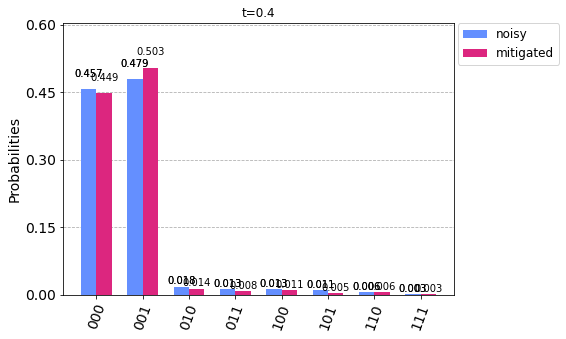

In [9]:
i=0
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(tvals[i]))

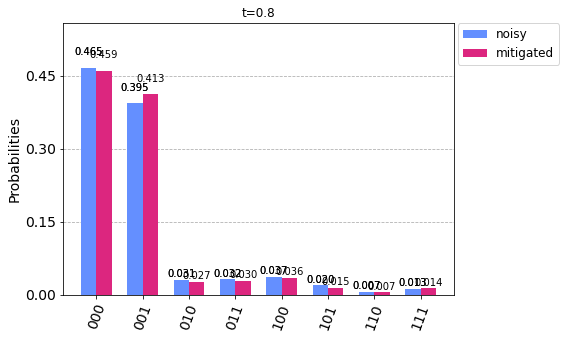

In [10]:
i=1
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(tvals[i]))

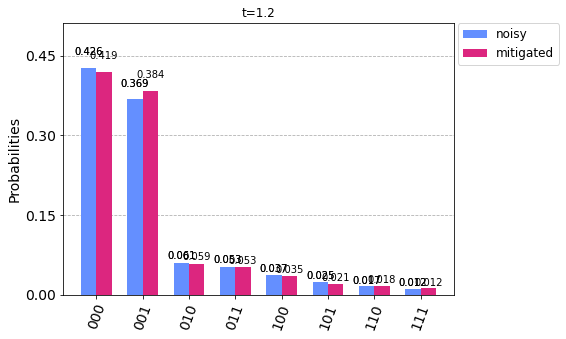

In [11]:
i=2
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(tvals[i]))

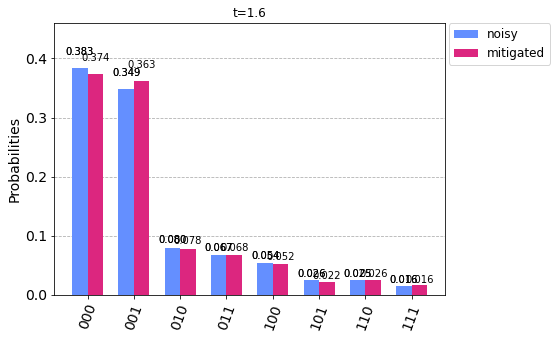

In [12]:
i=3
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(tvals[i]))

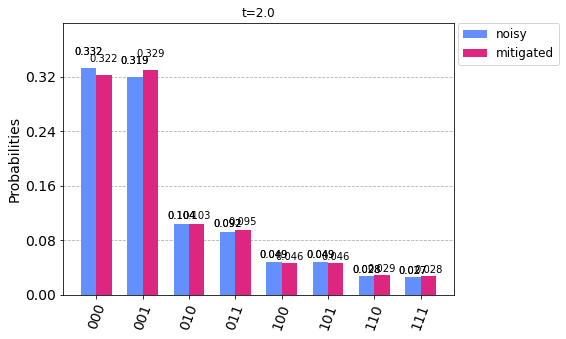

In [13]:
i=4
plot_histogram([noisy_counts[i], mitigated_counts[i]], legend=['noisy', 'mitigated'], title='t='+str(tvals[i]))

## Save raw data to cloud here

## Analyze results

_Add post-readout selection *before* 

- Clement & Sara will work on this
_Will ultimatley be separate file._
_What observables can we look at?_

- Fermion number
- Meson correlator for 2 sites?

_Need to implement readout post-selection_


mean fermion number (noisy)
t=0.4: nf = 0.511 +/- 0.01553
t=0.8: nf = 0.439 +/- 0.01497
t=1.2: nf = 0.439 +/- 0.01548
t=1.6: nf = 0.442 +/- 0.01561
t=2.0: nf = 0.471 +/- 0.01642

mean fermion number (corrected for readout error)
t=0.4: nf = 0.51635 +/- 0.01562
t=0.8: nf = 0.44149 +/- 0.01556
t=1.2: nf = 0.44175 +/- 0.0152
t=1.6: nf = 0.44498 +/- 0.01539
t=2.0: nf = 0.476 +/- 0.01612


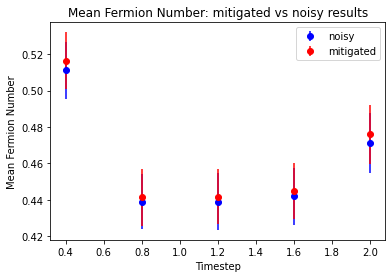

In [16]:
noisy_means = []
mitigated_means = []
noisy_errs = []
mitigated_errs = [] 

# caclulate average particle occupancy on site corresponding to n'th qubit
for i,t in enumerate(tvals):
    
    # first noisy data
    mean, err = get_particle_number(noisy_counts[i], nshots, -1)
    noisy_means.append(mean) 
    noisy_errs.append(err)
    
    # then data corrected for readout error
    mean, err = get_particle_number(mitigated_counts[i], nshots, -1)
    mitigated_means.append(mean)
    mitigated_errs.append(err)

print('\nmean fermion number (noisy)')
for i, nf in enumerate(noisy_means):
    print(f't={tvals[i]}: nf = {round(nf,5)} +/- {round(noisy_errs[i],5)}')
    
print('\nmean fermion number (corrected for readout error)')
for i, nf in enumerate(mitigated_means):
    print(f't={tvals[i]}: nf = {round(nf,5)} +/- {round(mitigated_errs[i],5)}')
    
plt.errorbar(tvals, noisy_means , yerr=noisy_errs, ls='', marker='o', color='b', label = 'noisy')
plt.errorbar(tvals, mitigated_means , yerr=mitigated_errs, ls='', marker='o', color='r', label = 'mitigated')
plt.xlabel('Timestep')
plt.ylabel('Mean Fermion Number')
plt.title('Mean Fermion Number: mitigated vs noisy results')
plt.legend()
plt.show()